In [1]:
import numpy as np
from matplotlib import pyplot as pl
import os
import scipy.io.wavfile as wav
import sys
from python_speech_features import mfcc
import mlp_backprop_momentum as mlp

%matplotlib inline

In [2]:
PATH = '/home/nums/Documents/MLG/lab04/vowels/'

In [54]:
# Empty array to store dataset trough iteration (sounds)
def create_dataset():
    dataset = np.array([], dtype=float).reshape(0,14)
    
    for filename in os.listdir(PATH):
        type = -1
        if(filename.startswith('nam') or filename.startswith('sam')):
            type = 0       
        elif (filename.startswith('naf') or filename.startswith('saf')):
            type = 100
        elif (filename.startswith('nk5') or filename.startswith('sk5')):
            type = 200
        else:
            type = 400
            
        #print("type:")
        #print(type)
        
        if(type < 300):
            sample_rate, X = wav.read(os.path.join(PATH, filename))
            coef = mfcc(X, samplerate=sample_rate, nfft=1024)
            coef = np.insert(coef,13,type,axis=1)
            dataset = np.append(dataset, coef,axis=0)
         
    return dataset
        
           

In [56]:
dataset = create_dataset()

In [4]:
def split_dataset(dataset, n_parts=5):
    n_rows = dataset.shape[0]
    index_all = np.arange(n_rows)
    np.random.shuffle(index_all)
    parts = []
    current_start = 0
    for p in np.arange(n_parts):
        current_end = current_start + int(np.floor(n_rows / (n_parts-p)))
        parts.append(dataset[index_all[current_start:current_end],:])
        n_rows -= current_end - current_start
        current_start = current_end
    return parts

In [6]:
split_dataset(create_dataset(),5)

[array([[ 19.96419654,   3.08637871,   1.82160203, ..., -12.2958531 ,
          -6.90883624,   1.        ],
        [ 20.98702346,   4.44860818, -28.74564813, ...,  -2.50617629,
          -0.66228456,   1.        ],
        [ 20.4296807 ,  -3.66743698, -17.36836235, ...,   0.34547415,
          -7.92108741,   0.        ],
        ...,
        [ 20.30452847,   3.88024513,  -3.92595527, ..., -12.05907794,
          -7.36313278,   1.        ],
        [ 20.81490363,  -3.30749537,  -9.72703567, ...,   8.84011162,
          21.80880992,   0.        ],
        [ 20.1110233 ,  18.77700281, -20.01330519, ...,   2.00961257,
          16.57537477,   0.        ]]),
 array([[ 21.45754789,  18.21439931, -14.97303379, ...,  -0.59923668,
          -9.52427437,   1.        ],
        [ 21.03784896,  -2.5456287 ,  -1.30433176, ...,   0.36633416,
           6.66067082,   1.        ],
        [ 19.54831095,   8.5531215 , -19.41643523, ...,   5.18824365,
           0.96861052,   1.        ],
        ...,


In [5]:
def k_fold_cross_validation(mlp, dataset, K=5, learning_rate=0.01, momentum=0.7, epochs=100):
    MSE_train_mean = 0.0
    MSE_test_mean = 0.0

    parts = split_dataset(dataset, K)
    
    for k in np.arange(K):
        mlp.init_weights()
        
        training_parts = set(np.arange(K))
        training_parts.remove(k)
        dataset_train = np.concatenate([parts[i] for i in list(training_parts)])
        dataset_test = parts[k]

        input_data = dataset_train[:,0:nn.n_inputs]
        output_data = dataset_train[:,nn.n_inputs:(nn.n_inputs+nn.n_outputs)]
        input_data_test = dataset_test[:,0:nn.n_inputs]
        output_data_test = dataset_test[:,nn.n_inputs:(nn.n_inputs+nn.n_outputs)]
        
        MSE_train = mlp.fit((input_data, output_data),
                            learning_rate=learning_rate, momentum=momentum, epochs=epochs)
        temp, _ = mlp.compute_MSE((input_data, output_data))
        MSE_train_mean += temp
        temp, _ = mlp.compute_MSE((input_data_test, output_data_test))
        MSE_test_mean += temp

    return (MSE_train_mean / K, MSE_test_mean / K)

In [6]:
N_SPLITS = 10
EPOCHS = 20
N_NEURONS = 2
K = 5
LEARNING_RATE = 0.001
MOMENTUM = 0.7
DATA_PARAMS = np.arange(0, 1)

In [18]:
MSE_train = np.zeros((len(DATA_PARAMS), N_SPLITS))
MSE_test = np.zeros((len(DATA_PARAMS), N_SPLITS))
nn = mlp.MLP([2,N_NEURONS,1], 'tanh')

print('Testing dataset')
dataset = create_dataset()

for d in np.arange(N_SPLITS):                                       # looping the splits
    sys.stdout.write('.')

    temp1, temp2 = k_fold_cross_validation(nn,
                                           dataset,
                                           K=K,
                                           learning_rate=LEARNING_RATE,
                                           momentum=MOMENTUM,
                                           epochs=EPOCHS)
    MSE_train[0,d] = temp1
    MSE_test[0,d] = temp2

print(N_SPLITS, ' tests done')

Testing dataset
..........10  tests done


In [66]:
datasetH = np.array([], dtype=float).reshape(0,14)
datasetF = np.array([], dtype=float).reshape(0,14)

datasetH = np.vstack((datasetH, dataset[dataset[:,13] == 0]))
datasetF = np.vstack((datasetF, dataset[dataset[:,13] == 100]))

print(datasetH[0])
        

[ 19.83859591  11.82569754 -35.2035731  -13.97026707   9.65975349
 -18.21720593 -13.75524441   6.30103559  31.52451406  24.80356174
 -19.16945598 -19.83944044   1.66385365   0.        ]


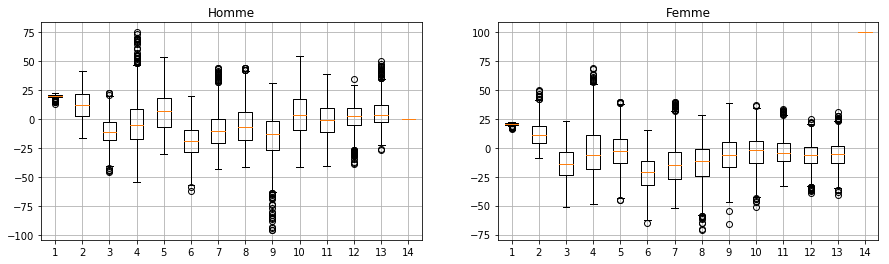

In [65]:
pl.figure(figsize=(15,4))
pl.subplot(1,2,1)
pl.boxplot(datasetH)
pl.title('Homme')
pl.grid()
pl.subplot(1,2,2)
pl.boxplot(datasetF)
pl.title('Femme')
pl.grid()


In [18]:
from python_speech_features import mfcc

In [24]:
ceps_1 = mfcc(X_1, samplerate=sample_rate_1, nfft=1024)
ceps_2 = mfcc(X_2, samplerate=sample_rate_2, nfft=1024)
print(ceps_1)
print( len(ceps_1))

[[ 19.36503542  16.34211171  -5.65565539 -20.96351122  -0.75445754
  -15.12912201  16.58647045  28.00034188 -17.22224266 -32.39525105
   11.28234057 -16.79879122  -7.9394457 ]
 [ 20.08652687  18.34431575  -7.33921498 -25.44367647  -4.0749357
  -19.22543447  18.96544989  19.89387591 -19.19940488 -34.14943069
    8.67262567 -16.72029323 -11.68722449]
 [ 20.46388133  20.07488033  -9.96018428 -28.91658557  -0.26448121
  -20.79430509  19.10807193  22.27466856 -17.69270288 -34.28853482
   12.00594013 -13.66305608  -9.62004755]
 [ 21.02560478  19.42326745 -13.41616506 -25.11513686  -1.4811129
  -16.90790321  23.67588395  23.32588409 -13.09358437 -35.19386476
   11.55288792 -11.49781566  -6.74603918]
 [ 21.40762266  18.2437834  -16.10061197 -23.88152156  -7.14075923
  -17.84666167  22.63223639  21.64091839 -13.45673529 -38.13061058
    6.30279588 -11.15904768  -5.85439623]
 [ 21.58143855  20.32797945 -16.01396007 -27.58519749  -3.28723264
  -20.02236807  19.32388219  26.11556472 -14.18182175 -

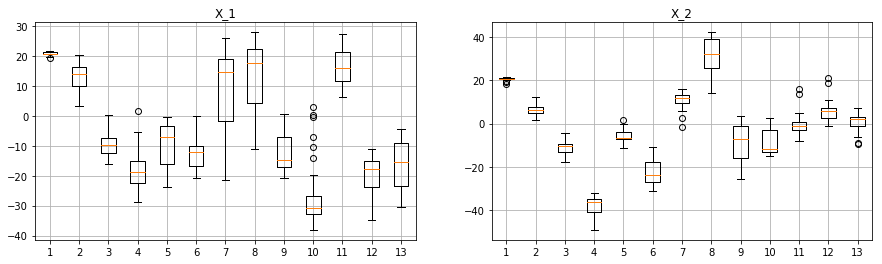

In [20]:
pl.figure(figsize=(15,4))
pl.subplot(1,2,1)
pl.boxplot(ceps_1)
pl.title('X_1')
pl.grid()
pl.subplot(1,2,2)
pl.boxplot(ceps_2)
pl.title('X_2')
pl.grid()